In [1]:
import duckdb
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

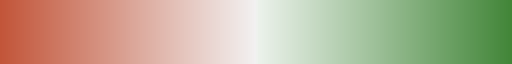

In [3]:
sns.set_theme()
sns.set_style('ticks', {"axes.grid": True})
sns.set_context('talk')
hm_w = 4.5
hm_h = 3.5
set_title = False
my_cmap = sns.diverging_palette(20, 125, as_cmap=True)
my_cmap

In [4]:
# flist = mpl.font_manager.get_fontconfig_fonts()
# for fname in flist:
#     name = mpl.font_manager.FontProperties(fname=fname).get_name()
#     if 'libertine' in name.lower():
#         print(fname)
#         print(name)
#         print()

In [5]:
# mpl.font_manager.fontManager.addfont('/Users/laurens/Library/Fonts/LinLibertine_R.ttf')
# mpl.font_manager.findfont("Linux Libertine")
# plt.rcParams['font.family'] = 'Linux Libertine'
# plt.rcParams['mathtext.fontset'] = 'stix'

In [6]:
my_palette = sns.diverging_palette(20, 125)
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

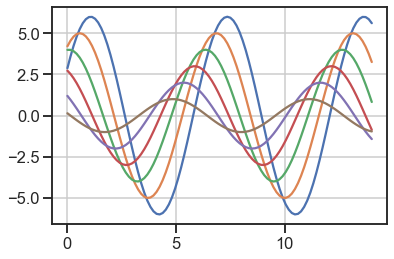

In [7]:
x = np.linspace(0, 14, 100)
for i in range(1, 7):
    plt.plot(x, np.sin(x + i * .5) * (7 - i) * 1)

In [8]:
con = duckdb.connect()
grouping_cols = ['count', 'columns', 'col_width', 'category']

# Functions

In [9]:
def load_csv(con, csv_path, median_cols):
    q = "select "
    q += ", ".join(grouping_cols)
    q += ", " + ", ".join([f"median({c}) as {c}" for c in median_cols])
    q += f" from read_csv_auto('{csv_path}') "
    q += "group by " + ", ".join(grouping_cols)
    q += " order by " + ", ".join(grouping_cols)
    con.execute(q)
    return con.fetchdf()

In [10]:
def compute_relative_runtime(con, df, cat1, cat2, col):
    q = "select\n\tcast(log2(c1.count) as int) as row_count,"
    q += f"\n\tc1.columns,\n\tc1.col_width,\n\tc1.{col} as {cat1}_{col},\n\tc2.{col} as {cat2}_{col},"
    q += f"\n\tround(c1.{col} / c2.{col}, 1) as relative_runtime"
    q += f"\nfrom\n\tdf c1,\n\tdf c2"
    q += f"\nwhere\n\tc1.category = '{cat1}'\nand\tc2.category = '{cat2}'\nand\t"
    q += "\nand\t".join([f"c1.{c} = c2.{c}" for c in grouping_cols[:-1]])
    q += "\norder by\n\trow_count,\n\t"
    q += ",\n\t".join([f"c1.{c}" for c in grouping_cols[1:-1]])
    con.execute(q)
    return con.fetchdf()

In [11]:
def get_color_norm(dfs, col):
    vmin = 1e99
    vmax = 0
    for df in dfs:
        vmin = min(vmin, min(df[col]))
        vmax = max(vmax, max(df[col]))
    if vmin < 1:
        vmin = 1 / vmin
    else:
        vmin = 1
    factor = min(max(1 / vmin, vmax), 4)
    vmin = 1 / factor
    vmax = factor
    return colors.TwoSlopeNorm(1, vmin=vmin, vmax=vmax)

In [12]:
def create_heatmap(df, columns, title, fname, w=hm_w, h=hm_h):
    color_norm = get_color_norm([df], columns[2])
    fig, ax = plt.subplots(figsize=(w, h))
    g = sns.heatmap(df.pivot(columns[0], columns[1], columns[2]), linewidths=0, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True, cbar=False, norm=color_norm)
    g.invert_yaxis()
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    if set_title:
        plt.title(f'Relative runtime of {title}')
    ax.set_xlabel('rows')
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

In [13]:
1.78**1.5

2.3748162034144875

In [14]:
def multi_heatmap(dfs, titles, columns, fname, w=hm_w, h=hm_h, normalize_colors=False):
    space_3 = 0.02
    space_else = 0.2
    actual_w = w * len(dfs)
    if len(dfs) != 3:
        actual_w += (len(dfs) - 1) * (space_else - space_3) * (1.8**(1 + len(dfs)/3.5))
    fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(actual_w, h), sharey=True)
    color_norm = get_color_norm(dfs, columns[2]) if normalize_colors else None
    
    for i in range(len(dfs)):
        ax = axes[i]
        sns.heatmap(dfs[i].pivot(columns[0], columns[1], columns[2]), linewidths=0, cbar=False, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True,
                    norm=color_norm)
        ax.invert_yaxis()
        for _, spine in ax.spines.items():
            spine.set_visible(True)
        labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
        ax.set_xlabel('rows')
        ax.set_title(titles[i])
        if i > 0:
            ax.set_ylabel('')
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='y', which='major', length=0)
    if len(dfs) == 3:
        plt.subplots_adjust(wspace=space_3)
    else:
        plt.subplots_adjust(wspace=space_else)
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

# Reordering

In [15]:
reorder_df = load_csv(con, 'results/reorder.csv', ['total', 'reorder', 'scatter', 'gather'])
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,2.717193e+10
1,row,3.640191e+10


In [16]:
reorder_total_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_total_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.426786,0.4


In [17]:
# create_heatmap(reorder_total_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'payload reordering rows vs. columns (incl. scatter + gather)',
#                'reorder_incl_sg')

In [18]:
reorder_only_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'reorder')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_only_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.069643,1.0


In [19]:
# create_heatmap(reorder_only_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'payload reordering rows vs. columns (excl. scatter + gather)',
#                'reorder_excl_sg')

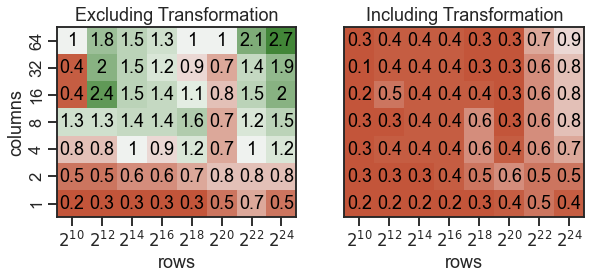

In [20]:
multi_heatmap([reorder_only_df, reorder_total_df], ['Excluding Transformation', 'Including Transformation'],
              ['columns', 'row_count', 'relative_runtime'],
              'reorder', w=4.5, h=3.5, normalize_colors=True)

In [21]:
# con.execute("""
#     select
#         cast(log2(count) as int) as row_count,
#         columns,
#         col_width,
#         reorder as "row reorder",
#         round(cast(scatter + gather as double) / total, 1) as sg
#     from
#         reorder_df
#     where
#         category = 'row'
#     order by
#         row_count asc,
#         columns asc
# """)
# reorder_percentage_df = con.fetchdf()
# con.execute('select avg(sg), median(sg) from reorder_percentage_df')
# con.fetchdf()

In [22]:
# create_heatmap(reorder_percentage_df,
#                ['columns', 'row_count', 'sg'],
#                'scatter + gather as percentage of reorder runtime',
#                'reorder_sg_percentage')

# Comparator

In [23]:
comparator_df = load_csv(con, 'results/comparator.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,8.135374e+10
1,col_branchless,1.724463e+11
2,col_ss,3.952873e+10
3,row_all,1.467897e+10
4,row_all_branchless,3.008843e+10
5,row_iter,1.186331e+10
6,row_norm,1.663921e+10


In [24]:
con.execute("""
select 
       min(1 - sort / total) as min_sg,
       max(1 - sort / total) as max_sg,
       avg(1 - sort / total) as avg_sg,
       median(1 - sort / total) as median_sg
from comparator_df
where category != 'col'
  and category != 'col_branchless'
  and category != 'col_ss'
-- order by category
""")
con.fetchdf()
# print(con.fetchdf().to_latex(index=False, float_format='%.2f'))

,min_sg,max_sg,avg_sg,median_sg
0,0.015632,0.354561,0.088069,0.063084


In [25]:
comparator_col_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'col_ss', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.775,1.8


In [26]:
# create_heatmap(comparator_col_iter_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'columnar_iterative vs. columnar_all (pdqsort)',
#                'comparator_col_iter')

In [27]:
comparator_col_branchless_df = compute_relative_runtime(con, comparator_df, 'col', 'col_branchless', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.55,0.5


In [28]:
# create_heatmap(comparator_col_branchless_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'columnar_branchless vs. columnar_all (pdqsort)',
#                'comparator_col_branchless')

In [29]:
comparator_col_baseline_df = compute_relative_runtime(con, comparator_df, 'col', 'col', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_baseline_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.0,1.0


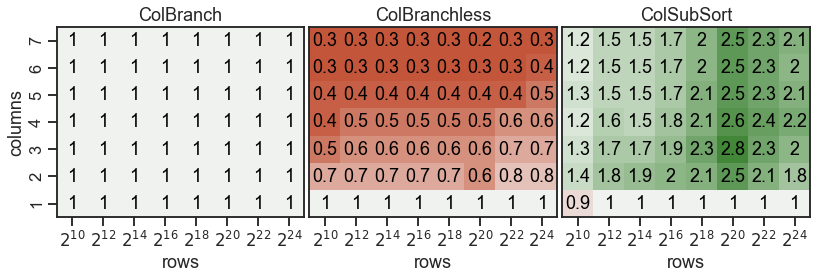

In [30]:
multi_heatmap([comparator_col_baseline_df, comparator_col_branchless_df, comparator_col_iter_df],
              ['ColBranch', 'ColBranchless', 'ColSubSort'],
              ['columns', 'row_count', 'relative_runtime'],
              'column_comparators', w=4.5, h=3.5, normalize_colors=True)

In [31]:
comparator_col_baseline_df2 = compute_relative_runtime(con, comparator_df, 'col', 'col', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_baseline_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.0,1.0


In [32]:
comparator_row_all_df = compute_relative_runtime(con, comparator_df, 'col', 'row_all', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_all_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.835714,1.8


In [33]:
# create_heatmap(comparator_row_all_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'row_all vs. columnar_iterative (pdqsort)',
#                'comparator_row_all')

In [34]:
comparator_row_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'row_iter', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,3.530357,2.25


In [35]:
# create_heatmap(comparator_row_iter_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'row_iter vs. columnar_iterative (pdqsort)',
#                'comparator_row_iter')

In [36]:
comparator_row_branchless_df = compute_relative_runtime(con, comparator_df, 'col', 'row_all_branchless', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.666071,1.1


In [37]:
# create_heatmap(comparator_row_branchless_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'row_all_branchless vs. row_all (pdqsort)',
#                'comparator_row_branchless')

In [38]:
comparator_norm_key_df = compute_relative_runtime(con, comparator_df, 'col', 'row_norm', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_norm_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.394643,1.7


In [39]:
# create_heatmap(comparator_norm_key_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'normalized_key vs. columnar_iterative (pdqsort)',
#                'comparator_norm_key')

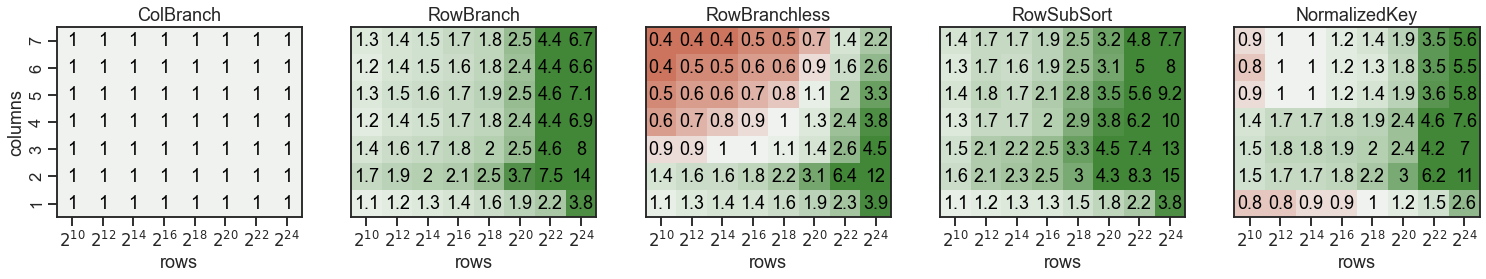

In [40]:
multi_heatmap([comparator_col_baseline_df, comparator_row_all_df, comparator_row_branchless_df, comparator_row_iter_df, comparator_norm_key_df],
              ['ColBranch', 'RowBranch', 'RowBranchless', 'RowSubSort', 'NormalizedKey'],
              ['columns', 'row_count', 'relative_runtime'],
              'row_comparators', w=4.5, h=3.5, normalize_colors=True)

# Sort

In [41]:
sort_skewed_df = load_csv(con, 'results/sort_skewed.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_skewed_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_static,1.434981e+10
1,radix,1.128488e+10


In [42]:
sort_skewed_rel_df = compute_relative_runtime(con, sort_skewed_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_skewed_rel_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.267857,1.3


In [43]:
# create_heatmap(sort_skewed_rel_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'pdq_static vs. radix',
#                'sort_skewed')

In [44]:
sort_random_df = load_csv(con, 'results/sort_random.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_random_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_static,1.499720e+10
1,radix,1.041385e+10


In [45]:
sort_random_rel_df = compute_relative_runtime(con, sort_random_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_random_rel_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.785714,1.6


In [46]:
# create_heatmap(sort_random_rel_df,
#                ['columns', 'row_count', 'relative_runtime'],
#                'pdq_static vs. radix',
#                'sort_random')

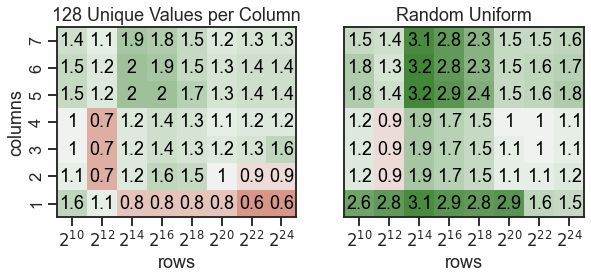

In [47]:
multi_heatmap([sort_skewed_rel_df, sort_random_rel_df],
              ['128 Unique Values per Column', 'Random Uniform'],
              ['columns', 'row_count', 'relative_runtime'],
              'sort', w=4.5, h=3.5, normalize_colors=True)

# Merge Key

In [48]:
merge_key_df = load_csv(con, 'results/merge_key.csv', ['total'])
con.execute("select category, sum(total) from merge_key_df group by category")
con.fetchdf()

,category,sum(total)
0,col_branch,1.848833e+09
1,col_branchless,4.043194e+09
2,row_all,6.606150e+08
3,row_all_branchless,1.720700e+09
4,row_norm,2.442101e+09


In [49]:
merge_key_col_branchless_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'col_branchless', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_col_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.473214,0.5


In [50]:
merge_key_row_branch_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'row_all', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_row_branch_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,3.191071,3.1


In [51]:
merge_key_row_branchless_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'row_all_branchless', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_row_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.269643,1.2


In [52]:
merge_key_norm_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'row_norm', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_norm_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.764286,0.7


In [53]:
merge_key_baseline_df = compute_relative_runtime(con, merge_key_df, 'col_branch', 'col_branch', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_baseline_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.0,1.0


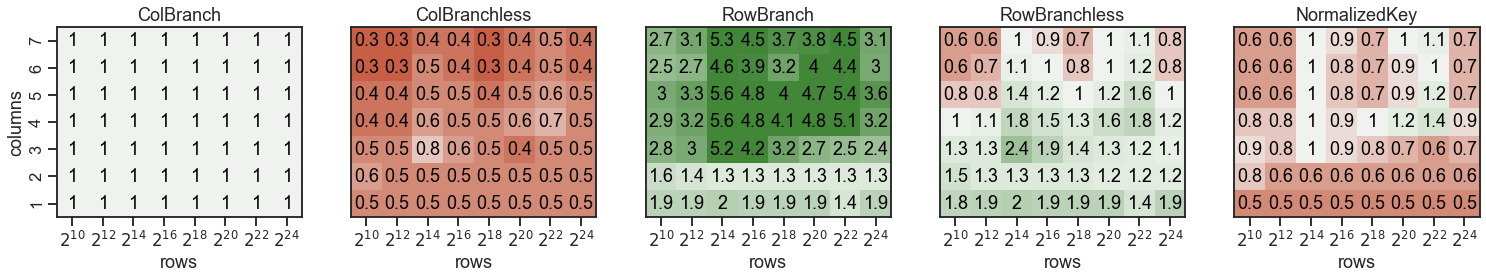

In [54]:
multi_heatmap([merge_key_baseline_df, merge_key_col_branchless_df, merge_key_row_branch_df, merge_key_row_branchless_df, merge_key_norm_df],
              ['ColBranch', 'ColBranchless', 'RowBranch', 'RowBranchless', 'NormalizedKey'],
              ['columns', 'row_count', 'relative_runtime'],
              'merge_key', w=4.5, h=3.5, normalize_colors=True)

# Merge Payload

In [55]:
merge_payload_df = load_csv(con, 'results/merge_payload.csv', ['total'])
con.execute("select category, sum(total) from merge_payload_df group by category")
con.fetchdf()

,category,sum(total)
0,col,1.084525e+10
1,row,9.336048e+09


In [56]:
merge_payload_runtime_df = compute_relative_runtime(con, merge_payload_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_payload_runtime_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.276786,1.1


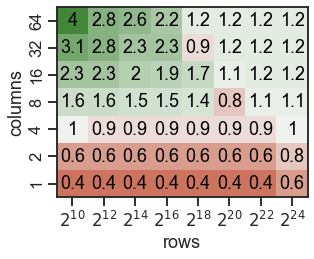

In [57]:
create_heatmap(merge_payload_runtime_df,
               ['columns', 'row_count', 'relative_runtime'],
               'merging rows vs. merging columns',
               'merge_payload')

# End-to-End

In [58]:
con.execute("select * from read_csv_auto('results/end_to_end.csv')")
end_to_end_df = con.fetchdf()
cols = [f'median({c}) as {c}' for c in end_to_end_df.columns[1:]]
con.execute(f"select category, {', '.join(cols)} from end_to_end_df group by category")
end_to_end_df = con.fetchdf()

In [59]:
end_to_end_df

,category,count,key_columns,payload_columns,col_width,init,scatter,sort,reorder,merge_key,merge_payload,gather,total
0,col,16777216.0,3.0,32.0,4.0,2.236093e+09,0.000000e+00,2.114490e+10,2.497780e+10,731826289.0,1.548289e+10,0.000000e+00,6.458474e+10
1,row,16777216.0,3.0,32.0,4.0,2.235485e+09,1.062767e+10,3.352461e+09,1.161396e+10,703742785.0,1.259718e+10,6.892458e+09,4.804074e+10
2,row_norm,16777216.0,3.0,32.0,4.0,2.236708e+09,1.063250e+10,3.857360e+09,1.178437e+10,924188262.0,1.263685e+10,6.885920e+09,4.893105e+10


In [60]:
ete_cols = list(end_to_end_df.columns[6:-1])
ete_cols.reverse()
ete_cols

['gather', 'merge_payload', 'merge_key', 'reorder', 'sort', 'scatter']

In [61]:
ete_fancy_cols = [
    'rows to columns',
    'merge payload',    
    'merge key data',    
    'reorder payload',
    'sort runs',    
    'columns to rows',
]
ete_fancy_cols.reverse()

In [62]:
con.execute(f"select (init + {' + '.join(ete_cols)})::DOUBLE / total from end_to_end_df")
con.fetchall()

[(0.9998259716061495,), (0.9996296149947904,), (1.0005489003887014,)]

In [63]:
unions = []
for col in ete_cols:
    unions.append(f"""select case when category='col' then 'Column' else case when category='row' then 'RowJIT' else 'RowVEC' end end as category,
    '{col}' as action, {col}::DOUBLE / 1e9 as time from end_to_end_df""")
q = ' union all '.join(unions)
con.execute(q)
ete_stacked_df = con.fetchdf()

In [64]:
tab20c = sns.color_palette('tab20c')
tab20c

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [65]:
tab20c = sns.color_palette('tab20c')
tab20c

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [66]:
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

In [67]:
for c in my_palette:
    for rgb in c:
        print(int(rgb * 255 + 0.5), end=' ')
    print()

195 85 58 
214 148 131 
233 210 205 
203 221 201 
134 177 128 
66 134 56 


In [68]:
ete_palette = [
    tab20c[17],
    my_palette[1],
    my_palette[0],
    my_palette[4],
    my_palette[5],
    tab20c[16]
]
for c in ete_palette:
    for rgb in c:
        print(int(rgb * 255 + 0.5), end=' ')
    print()

150 150 150 
214 148 131 
195 85 58 
134 177 128 
66 134 56 
99 99 99 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


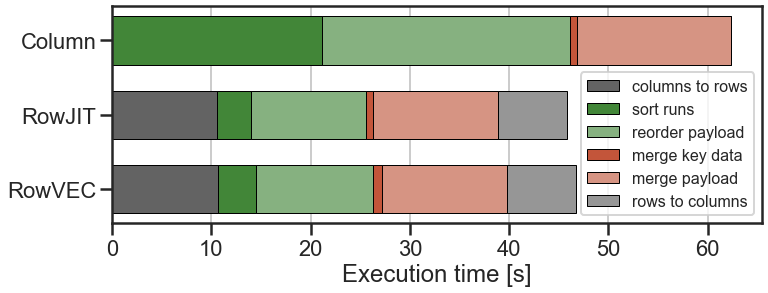

In [69]:
sns.set_context('poster')
plt.figure(figsize=(11.2, 4.6))
ax = sns.histplot(
    ete_stacked_df,
    
    y='category',
    weights='time',
    hue='action',
    multiple='stack',
    
    palette=ete_palette,
    linewidth=1,
    edgecolor='black',
    
    shrink=0.65,
    alpha=1,
    element='bars'
)
ax.grid(None, axis='y')
legend = ax.legend(labels=ete_fancy_cols, fontsize=16)
ax.set_xlabel('Execution time [s]')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('figures/end_to_end.eps', bbox_inches='tight')

In [70]:
sns.set_context('talk')

# Static vs. Dynamic

In [71]:
mem_colors = [my_palette[0], my_palette[5]]

In [72]:
platforms = ['x86_clang', 'arm_clang']

In [73]:
q = []
for platform in platforms:
    q.append(f"select 'memcpy' as function, '{platform}' as platform, * from read_csv_auto('results/memcpy_{platform}.csv')")
    q.append(f"select 'memcmp' as function, '{platform}' as platform, * from read_csv_auto('results/memcmp_{platform}.csv')")
con.execute(' union all '.join(q))
mem_df = con.fetchdf()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


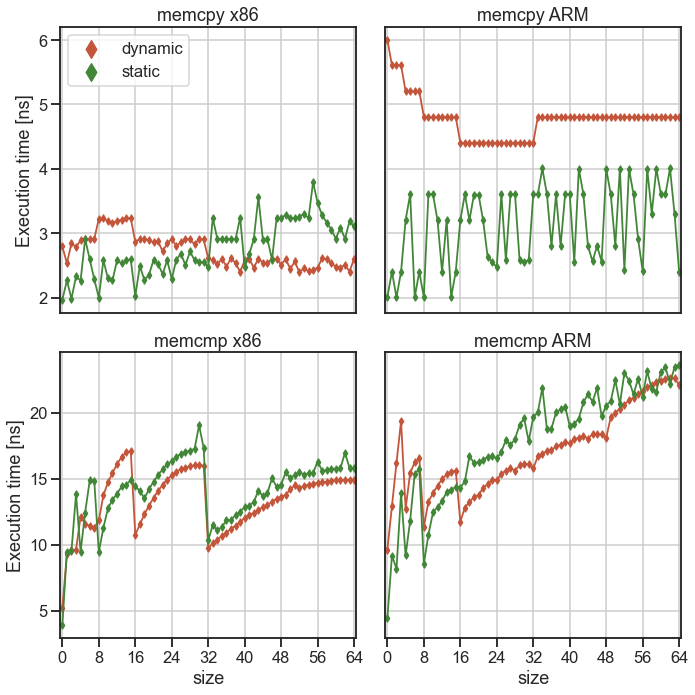

In [74]:
with plt.rc_context({'lines.linewidth': 1}):
    plot = sns.catplot(data=mem_df, kind='point', x='num_bytes', y='time', col='platform', hue='type',
                       sharex='col', sharey="row", row="function", markers=['d', 'd'], palette=mem_colors,
                       facet_kws=dict(despine=False), legend=False)

plot.axes[0][0].set(ylabel='Execution time [ns]', title='memcpy x86')
plot.axes[0][1].set(ylabel=None, title='memcpy ARM')
plot.axes[1][0].set(ylabel='Execution time [ns]', xlabel='size', title='memcmp x86')
plot.axes[1][1].set(ylabel=None, xlabel='size', title='memcmp ARM')

for i, arr in enumerate(plot.axes):
    for j, ax in enumerate(arr):
        ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
        ax.grid(True)
        for col in ax.collections:
            col.set_sizes([25])
        
        if i == 0:
            ax.tick_params(axis='x', which='major', length=0)
        if j == 1:
            ax.tick_params(axis='y', which='major', length=0)

# plot._legend.set_visible(False)
with plt.rc_context({'legend.markerscale': 2.5}):
    lgnd = plot.axes[0][0].legend(loc='upper left')

# plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.savefig('figures/mem.eps', bbox_inches='tight')

In [75]:
con.execute("""
select max(d.time / s.time) as speedup, d.function, d.num_bytes, d.platform
from mem_df d, mem_df s
where d.type = 'dynamic'
and s.type = 'static'
and d.function = s.function
and d.num_bytes = s.num_bytes
and d.platform = s.platform
group by d.function, d.num_bytes, d.platform
order by speedup desc
""")
speedup = con.fetchdf()
speedup.head(20)

,speedup,function,num_bytes,platform
0,2.987653,memcpy,0,arm_clang
1,2.798511,memcpy,2,arm_clang
2,2.593695,memcpy,6,arm_clang
3,2.394411,memcpy,8,arm_clang
4,2.390642,memcpy,14,arm_clang
5,2.337190,memcpy,3,arm_clang
6,2.334504,memcpy,1,arm_clang
7,2.183795,memcmp,0,arm_clang
8,2.169123,memcpy,7,arm_clang
9,2.003870,memcpy,12,arm_clang


# Trace

In [76]:
def process_trace_csv(con, csv_path, counter, ns_per_grp):
    time_group_size = 20000000
    if counter is 'cm':
        counter = 'L1D_CACHE_MISS_LD + L1D_CACHE_MISS_ST'
    elif counter is 'bm':
        counter = 'BRANCH_COND_MISPRED_NONSPEC'
    else:
        '4' + 2
    con.execute(f"""
    with trace_csv1 as (select * from read_csv_auto('{csv_path}', sample_size=30000)),
    trace_csv2 as (
        select
            category,
            cast(time / {ns_per_grp} as bigint) as time,
            {counter} as counter
        from trace_csv1
    ),
    trace_csv3 as (
        select category, time, sum(counter) counter
        from trace_csv2
        group by category, time
    ),
    trace_csv4 as (
        select category, time, counter,
               cast(lag(time, 1) over (partition by category order by time) as int) as lg1
        from trace_csv3
    ),
    bounds as (
        select * from trace_csv4
        where time - 1 != lg1
    ),
    filtered as (
        select *
        from trace_csv4 t
        where
            time >= (select min(time) from bounds b where t.category = b.category)
        and time < (select max(time) from bounds b where t.category = b.category)
    ),
    trace as (
        select
            category,
            (time - (select min(time) from filtered fs where f.category = fs.category group by category)) * {ns_per_grp} as time,
            counter
        from filtered f
    )
    select category,
    time,
    sum(counter) over (partition by category order by time rows between unbounded preceding and current row) counter
    from trace
    """)
    r1 = con.fetchdf()
    
    con.execute(f"""
    with continuous as (
        select *, lag(time, 1) over (partition by category order by time) as lg1
        from r1
    )
    select category, time, counter
    from continuous
    where time = lg1 + {ns_per_grp}
       or lg1 is null
    order by category, time
    """)
    r2 = con.fetchdf()
    
    print('rows:', len(r2))
    con.execute("select max(time) from r2")
    print('max time:', con.fetchall()[0][0])
    return r2

In [77]:
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

In [78]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [79]:
my_palette2 = sns.color_palette("hls", 8)
my_palette2

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

In [80]:
trace_palette_map = {
    'Branch': my_palette[0],
    'Branchless': my_palette[5],
    'SubSort': my_palette2[1],
    'NormalizedKey': my_palette2[6]
}

In [120]:
def plot_trace(df, counter, fig_name, categories=None, h=5, asp=1, the_ax=None, lg=False, yl=True, title=None):
    if categories:
        if len(categories) == 2:
            palette = [my_palette[0], my_palette[5]]
            markers = ['d', 'd']
        else:
            markers = ['d' if 'Col' in cat else 's' for cat in categories]
            palette = [trace_palette_map.get(cat.replace('Col', '').replace('Row', ''), my_palette[0]) for cat in categories]
    else:
        markers = ['d']*20
        palette = sns.color_palette()
    with plt.rc_context({'lines.linewidth': 1}):
        if not the_ax:
            plot = sns.catplot(kind='point', data=df, x='time', y='counter', hue='category',
                               markers=markers, facet_kws=dict(despine=False),
                               palette=palette, legend=False, h=h, aspect=asp)
            ax = plot.axes[0][0]
        else:
            ax = sns.pointplot(data=df, x='time', y='counter', hue='category',
                               markers=markers, facet_kws=dict(despine=False),
                               palette=palette, ax=the_ax, legend=False)
        ax.legend([], [], frameon=False)
    
    if max(df['counter']) / 1e9 > 1:
        q = '× 1e9'
        y_divisor = 1e9
    elif max(df['counter']) / 1e6 > 1:
        q = '× 1e6'
        y_divisor = 1e6
    elif max(df['counter']) / 1e3 > 1:
        q = '× 1e3'
        y_divisor = 1e3

    if counter == 'cm':
        ylabel = f'Cache misses {q}'
    else:
        ylabel = f'Branch mispredictions {q}'
    
    if yl:
        ax.set(ylabel=ylabel, xlabel='Execution time [s]')
    else:
        ax.set(ylabel='', xlabel='Execution time [s]')
        ax.set_ylabel('')
#         plt.setp(ax.get_yticklabels(), visible=False)
        plt.subplots_adjust(wspace=0)

    ax.set_title(title)
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f'{float(label) / 1e9}' for label in xlabels])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
#     ax.tick_params(axis='y', which='major', length=0)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: float(x / y_divisor)))

    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([25])

    if lg:
        with plt.rc_context({'legend.markerscale': 2}):
            lgnd = ax.legend(fontsize='small')
        if categories:
            for new, old in zip(categories, lgnd.get_texts()):
                old.set_text(new)
    return ax

In [82]:
def multi_trace(dfs, fig_name, categories, counters, h=5, asp=1, lg=0, titles=[None, None]):
    shy = counters[0] == counters[1]
    plot, axes = plt.subplots(nrows=1, ncols=2, figsize=(2 * h * asp, h), sharey=shy)
    for i in range(2):
        legend_on = lg == i
        if i == 1 and counters[0] == counters[1]:
            yl = False
        else:
            yl = True
        plot_trace(dfs[i], counters[i], '', categories=categories, h=h, asp=asp, the_ax=axes[i],
                   lg=legend_on, yl=yl, title=titles[i])
    plt.tight_layout()
    plt.savefig(f'figures/{fig_name}.eps', bbox_inches='tight')
    plt.show()

## Reorder

In [83]:
agg_ns = 100000000
# cm_reorder_excl_df = process_trace_csv(con, 'results/trace_reorder_excl.csv', 'cm', agg_ns)
cm_reorder_incl_df = process_trace_csv(con, 'results/trace_reorder_incl.csv', 'cm', agg_ns)

rows: 53
max time: 2600000000


In [84]:
# plot_trace(cm_reorder_excl_df, 'cm', 'cm_reorder_excl', ['Columns', 'Rows'], h=5, asp=1.5, lg=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


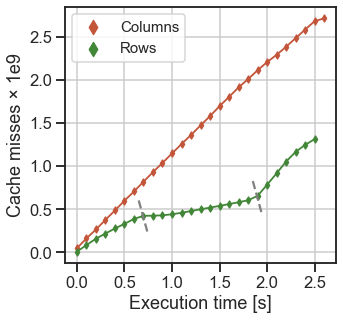

In [149]:
ax = plot_trace(cm_reorder_incl_df, 'cm', 'trace_reorder', ['Columns', 'Rows'], h=4.75, asp=1.133, lg=True)
ax.plot([6.5, 7.5], [6e8, 2e8], linestyle='dashed', c='gray')
ax.plot([18.5, 19.5], [8.25e8, 4.25e8], linestyle='dashed', c='gray')
plt.savefig(f'figures/trace_reorder.eps', bbox_inches='tight')

In [130]:
500000000/2847153866

0.17561397224465986

In [122]:
print(ax)

AxesSubplot(0.188327,0.1915;0.66663x0.712833)


In [86]:
# con.execute("select * from cm_reorder_incl_df union all select 'row excl', time, counter from cm_reorder_excl_df where category = 'row'")
# cm_reorder_df = con.fetchdf()

In [87]:
# multi_trace([cm_reorder_incl_df, cm_reorder_excl_df], 'trace_reorders', ['Columns', 'Rows'],
#             ['cm', 'cm'], h=4.5, asp=1.25, lg=0, titles=['Including Transformation', 'Excluding Transformation'])
# plot_trace(cm_reorder_df, 'cm', 'cm_reorder', ['Columns', 'Rows Excl.', 'Rows Incl.'], h=5, asp=1.5, lg=True)

In [88]:
# bm_reorder_df = process_trace_csv(con, 'results/trace_reorder.csv', 'bm', 20000000)

In [89]:
# plot_trace(bm_reorder_df, 'bm', 'bm_reorder', ['Columns', 'Rows'], h=5, asp=1.5)

## Comparator

In [90]:
agg_ns = 100000000
cm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'cm', agg_ns)
bm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'bm', agg_ns)

rows: 122
max time: 3900000000
rows: 122
max time: 3900000000


In [91]:
comp_cats = ['ColBranch',
            'ColBranchless',
            'ColSubSort',
            'RowBranch',
            'RowBranchless',
            'RowSubSort',
            'NormalizedKey']

In [92]:
# plot_trace(cm_comparator_df, 'cm', 'cm_comparator', categories=comp_cats, h=6.5, asp=1.5)

In [93]:
# plot_trace(bm_comparator_df, 'bm', 'bm_comparator', categories=comp_cats, h=6.5, asp=1.5)

In [94]:
# multi_trace([cm_comparator_df, bm_comparator_df],
#             'trace_comparators', comp_cats, ['cm', 'bm'], h=5, asp=1.25, lg=0)

In [95]:
agg_ns = 10000000
cm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'cm', agg_ns)
bm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'bm', agg_ns)
con.execute("select max(counter) from cm_comparator_df where category = 'row_iter'")
con.fetchall()

rows: 1159
max time: 3920000000
rows: 1159
max time: 3920000000


[(97308148.0,)]

In [96]:
con.execute("""
with joined as (
    select cm.category, cm.time, cm.counter as cache_misses, bm.counter as branch_mispredictions
    from cm_comparator_df cm, bm_comparator_df bm
    where cm.category = bm.category
    and cm.time = bm.time
)
select
    category,
    max(time)::DOUBLE / 1000000000 as time_s,
    sum(cache_misses) / 1000000000 as cache_misses_billions,
    sum(branch_mispredictions) / 1000000000 as branch_mispredictions_billions
from joined
group by category
""")
res = con.fetchall()
print('\\toprule')
print('Approach & ExecutionTime [s] & CM × 1e9 & BM × 1e9 \\\\')
print('\\midrule')
for i, row in enumerate(res):
    print(f'\\textit{{{comp_cats[i]}}} & ' + ' & '.join([f'{v:.2f}' for v in row[1:]]) + ' \\\\')
print('\\bottomrule')

\toprule
Approach & ExecutionTime [s] & CM × 1e9 & BM × 1e9 \\
\midrule
\textit{ColBranch} & 3.27 & 126.58 & 14.82 \\
\textit{ColBranchless} & 3.92 & 144.19 & 6.01 \\
\textit{ColSubSort} & 1.36 & 29.59 & 1.42 \\
\textit{RowBranch} & 0.81 & 3.10 & 3.59 \\
\textit{RowBranchless} & 0.88 & 3.36 & 1.08 \\
\textit{RowSubSort} & 0.46 & 3.18 & 0.63 \\
\textit{NormalizedKey} & 0.82 & 3.05 & 2.77 \\
\bottomrule


## Sort

In [97]:
agg_ns = 20000000
cm_sort_df = process_trace_csv(con, 'results/trace_sort.csv', 'cm', agg_ns)
bm_sort_df = process_trace_csv(con, 'results/trace_sort.csv', 'bm', agg_ns)

rows: 70
max time: 820000000
rows: 70
max time: 820000000


In [98]:
# plot_trace(cm_sort_df, 'cm', 'cm_sort', lg=True)

In [99]:
# plot_trace(bm_sort_df, 'bm', 'bm_sort', lg=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


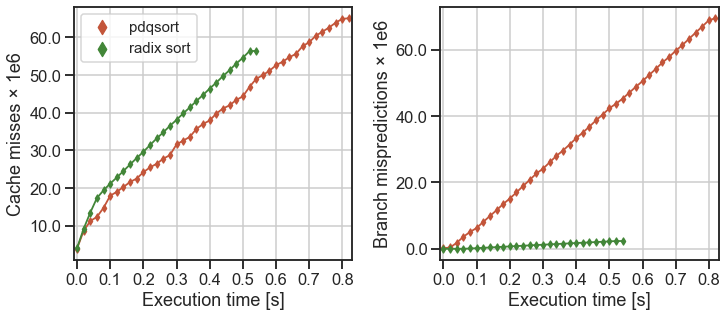

In [116]:
multi_trace([cm_sort_df, bm_sort_df],
            'trace_sort', ['pdqsort', 'radix sort'], ['cm', 'bm'], h=4.75, asp=1.1, lg=0)

## Key Merge

In [101]:
agg_ns = 5000000
cm_merge_key_df = process_trace_csv(con, 'results/trace_merge_key.csv', 'cm', agg_ns)
bm_merge_key_df = process_trace_csv(con, 'results/trace_merge_key.csv', 'bm', agg_ns)

rows: 172
max time: 300000000
rows: 172
max time: 300000000


In [102]:
comp_cats = ['ColBranch', 'ColBranchless', 'RowBranch', 'RowBranchless', 'NormalizedKey']

In [103]:
con.execute("""
with joined as (
    select cm.category, cm.time, cm.counter as cache_misses, bm.counter as branch_mispredictions
    from cm_merge_key_df cm, bm_merge_key_df bm
    where cm.category = bm.category
    and cm.time = bm.time
)
select
    category,
    max(time)::DOUBLE / 1000000000 as time_s,
    sum(cache_misses) / 1000000 as cache_misses_billions,
    sum(branch_mispredictions) / 1000 as branch_mispredictions_billions
from joined
group by category
""")
res = con.fetchall()
print('\\toprule')
print('Approach & Time [s] & CM × 1e6 & BM × 1e3 \\\\')
print('\\midrule')
for i, row in enumerate(res):
    print(f'\\textit{{{comp_cats[i]}}} & ' + ' & '.join([f'{v:.2f}' for v in row[1:]]) + ' \\\\')
print('\\bottomrule')

\toprule
Approach & Time [s] & CM × 1e6 & BM × 1e3 \\
\midrule
\textit{ColBranch} & 0.20 & 125.49 & 632.03 \\
\textit{ColBranchless} & 0.30 & 172.69 & 102.29 \\
\textit{RowBranch} & 0.09 & 32.90 & 0.96 \\
\textit{RowBranchless} & 0.15 & 55.66 & 0.21 \\
\textit{NormalizedKey} & 0.10 & 37.91 & 63.79 \\
\bottomrule


In [104]:
# plot_trace(cm_merge_key_df, 'cm', 'cm_merge_key', h=4.5, asp=1.2, lg=True)

In [105]:
# plot_trace(bm_merge_key_df, 'bm', 'bm_merge_key', h=4.5, asp=1.2, lg=True)

In [106]:
# multi_trace([cm_merge_key_df, bm_merge_key_df],
#             'trace_merge_key', ['ColBranch', 'ColBranchless', 'RowBranch', 'RowBranchless', 'NormalizedKey'],
#             ['cm', 'bm'], h=4.5, asp=1.2, lg=0)

## Payload Merge

In [107]:
agg_ns = 20000000
cm_merge_payload_df = process_trace_csv(con, 'results/trace_merge_payload.csv', 'cm', agg_ns)
bm_merge_payload_df = process_trace_csv(con, 'results/trace_merge_payload.csv', 'bm', agg_ns)

rows: 75
max time: 880000000
rows: 75
max time: 880000000


In [108]:
# plot_trace(cm_merge_payload_df, 'cm', 'cm_merge_payload', lg=True)

In [109]:
# plot_trace(bm_merge_payload_df, 'bm', 'bm_merge_payload')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


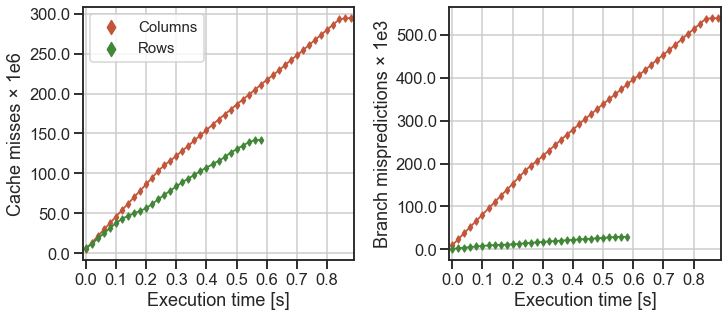

In [117]:
multi_trace([cm_merge_payload_df, bm_merge_payload_df],
            'trace_merge_payload', ['Columns', 'Rows'],
            ['cm', 'bm'], h=4.75, asp=1.1, lg=0)

# Templating ...

In [111]:
# for i in range(1, 257):
#     print(f'\tcase {i}:')
#     print(f'\t\treturn memcmp_fixed<{i}>(str1, str2);')

In [112]:
# for i in range(1, 257):
#     print(f'\tcase {i}:')
#     print(f'\t\treturn MemcpyFixed<{i}>(dest, src);')

In [113]:
# row = 'BranchedRowOrderEntry'
# row = 'BranchlessRowOrderEntry'
# row = 'NormalizedRowOrderEntry'
# print('switch (columns){')
# for i in range(1, 8):
#     print(f'case {i}:')
#     print(f'return MergeKeyRows<{row}{i}<T>>(left, right, count);')
# print('default:')
# print('assert(false);')
# print('}')